In [1]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
(X_train, Y_train),(_, _) = K.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


5


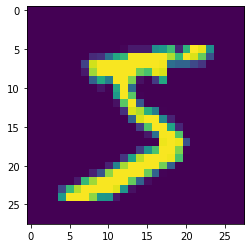

In [3]:
print(Y_train[0])
plt.imshow(X_train[0])

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28)
(60000,)


In [4]:
# (batch, h, w, channels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float32')
print(X_train.shape)

(60000, 28, 28, 1)


In [5]:
# normalizing
X_train = (X_train - 127.5)/127.5

In [6]:
# shuffling the whole dataset
BUFFER_SIZE = X_train.shape[0]

# splitting into batches
BATCH_SIZE = 256

# creating dataset
trainingData = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Models

In [8]:
def getGeneratorModel():
  model = K.models.Sequential([
                  # we will take an image of 7x7x256 as input, and this will be flattened
                  # taking input as 100 random numbers
                  layers.Dense(7*7*256, input_shape= (100,)),
                  # normalizing the input so it doesn't explode
                  layers.BatchNormalization(),
                  layers.Reshape((7, 7, 256)),
                  layers.LeakyReLU(),
                  # inverse of convolution is the same as the transpose of the convolution
                  # we want to start reducing the depth now
                  layers.Conv2DTranspose(128, (5, 5), padding = 'same'),
                  layers.BatchNormalization(),
                  layers.LeakyReLU(),
                  
                  # pooling is proved to be harmful with GANs
                  # we use strides instead of pooling to upsample
                  layers.Conv2DTranspose(64, (5, 5), padding = 'same', strides = 2),
                  layers.BatchNormalization(),
                  layers.LeakyReLU(),
                  # now we have a 14x14 image as we had strides = 2, so 7*2 upsample

                  # now we reduce the depth to 1, and again upsample by a factor of 2
                  layers.Conv2DTranspose(1, (5, 5), padding = 'same', strides = 2, activation = 'tanh')
                  ])
  assert model.output_shape == (None, 28, 28, 1)
  
  return model

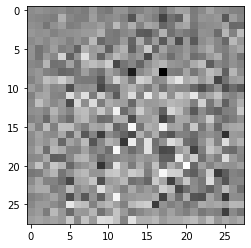

In [9]:
generator = getGeneratorModel()

noise = tf.random.normal([1, 100])
generatedImage = generator(noise, training=False)

plt.imshow(generatedImage[0, :, :, 0], cmap = 'gray')

In [10]:
def getDiscriminatorModel():
  model = K.models.Sequential([
            layers.Conv2D(64, (5, 5), strides = 2, padding = 'same', input_shape = (28, 28, 1)),

            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Flatten(),
            layers.Dense(1),
            ])
  
  return model

In [11]:
discriminator = getDiscriminatorModel()

In [12]:
decision = discriminator(generatedImage)
print(decision)

tf.Tensor([[0.00040589]], shape=(1, 1), dtype=float32)


# Loss

In [13]:
def getGeneratorLoss(fakePreds):
  # fakePreds = tf.sigmoid(fakePreds)

  # here, the generator should give out FAKES, hence the ideal output should be 1
  # so, we take loss here w.r.t 1
  # fakeLoss = tf.losses.binary_crossentropy(tf.ones_like(fakePreds), fakePreds)
  fakeLoss = cross_entropy(tf.ones_like(fakePreds), fakePreds)

  return fakeLoss

In [14]:
def getDiscriminatorLoss(realPreds, fakePreds):
  # get predictions between 0 and 1
  # realPreds = tf.sigmoid(realPreds)
  # fakePreds = tf.sigmoid(fakePreds)

  # for real predictions, we must have a value of one, hence loss must be taken w.r.t 1
  # realLoss = tf.losses.binary_crossentropy(tf.ones_like(realPreds), realPreds)
  realLoss = cross_entropy(tf.ones_like(realPreds), realPreds)

  # for fake predictions, we must have a value of zero, hence loss must be taken w.r.t 0
  # fakeLoss = tf.losses.binary_crossentropy(tf.zeros_like(fakePreds), fakePreds)
  fakeLoss = cross_entropy(tf.zeros_like(fakePreds), fakePreds)

  # print("[Debugging] " + str(fakeLoss.shape) + " " + str(realLoss.shape))

  return fakeLoss + realLoss

# Optimizers

In [15]:
discriminatorOptimizer = K.optimizers.Adam(lr = 1e-4)
generatorOptimizer = K.optimizers.Adam(lr = 1e-4)

# Training

In [27]:
EPOCHS = 100
noiseDim = 100
numberOfExamplesToGenerate = 16

seed = tf.random.normal([numberOfExamplesToGenerate, noiseDim])

In [28]:
def train(dataset, epochs):
    gLoss = None
    dLoss = None
    for epoch in range(epochs):
        print("Running epoch : " + str(epoch + 1))
        
        for images in dataset:
            gLoss, dLoss = trainStep(images)
        
        if (epoch+1)%5 == 0:
          print("GEN Loss: " + str(gLoss))
          print("DISC Loss: " + str(dLoss))

In [29]:
@tf.function
def trainStep(images):
  # random noise input
  # we are giving 100 random numbers to the generator, hence we want 100 random numbers
  # we have a batch size of BATCH_SIZE
  noise = tf.random.normal([BATCH_SIZE, noiseDim])   # BATCH_SIZE number of random noise images

  with tf.GradientTape() as genTape, tf.GradientTape() as discTape:
    # passing noise through the generator model to get back an image of 28x28
    generatedImages = generator(noise, training = True)

    # getting output from the discriminator
    realOutput = discriminator(images, training = True)
    fakeOutput = discriminator(generatedImages, training = True)

    # getting loss from both models
    generatorLoss = getGeneratorLoss(fakeOutput)
    discriminatorLoss = getDiscriminatorLoss(realOutput, fakeOutput)
    
  # passing the loss and then the trainable variables of the model for back prop
  genGradients = genTape.gradient(generatorLoss, generator.trainable_variables)
  discGradients = discTape.gradient(discriminatorLoss, discriminator.trainable_variables)

  # using the previously declared optimizers for gradient descent
  generatorOptimizer.apply_gradients(zip(genGradients, generator.trainable_variables))
  discriminatorOptimizer.apply_gradients(zip(discGradients, discriminator.trainable_variables))    

  return generatorLoss, discriminatorLoss

In [30]:
# training over training dataset and 2 epochs
train(trainingData, EPOCHS)

Running epoch : 1
Running epoch : 2
Running epoch : 3
Running epoch : 4
Running epoch : 5
GEN Loss: tf.Tensor(0.8145065, shape=(), dtype=float32)
DISC Loss: tf.Tensor(1.2315667, shape=(), dtype=float32)
Running epoch : 6
Running epoch : 7
Running epoch : 8
Running epoch : 9
Running epoch : 10
GEN Loss: tf.Tensor(0.96443, shape=(), dtype=float32)
DISC Loss: tf.Tensor(1.2304423, shape=(), dtype=float32)
Running epoch : 11
Running epoch : 12
Running epoch : 13
Running epoch : 14
Running epoch : 15
GEN Loss: tf.Tensor(0.7834953, shape=(), dtype=float32)
DISC Loss: tf.Tensor(1.3014753, shape=(), dtype=float32)
Running epoch : 16
Running epoch : 17
Running epoch : 18
Running epoch : 19
Running epoch : 20
GEN Loss: tf.Tensor(1.0339652, shape=(), dtype=float32)
DISC Loss: tf.Tensor(1.1720259, shape=(), dtype=float32)
Running epoch : 21
Running epoch : 22
Running epoch : 23
Running epoch : 24
Running epoch : 25
GEN Loss: tf.Tensor(1.0338331, shape=(), dtype=float32)
DISC Loss: tf.Tensor(1.27944

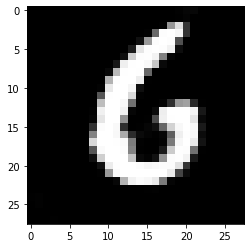

In [40]:
# now predicting
plt.imshow(tf.reshape(generator(np.random.randn(1, 100)), (28, 28)), cmap='gray')

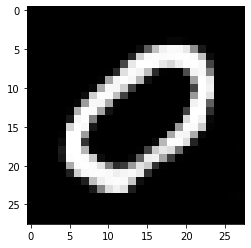

In [43]:
plt.imshow(tf.reshape(generator(np.random.randn(1, 100)), (28, 28)), cmap='gray')

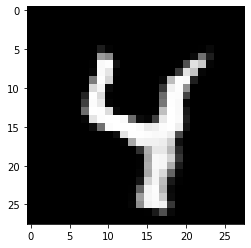

In [50]:
plt.imshow(tf.reshape(generator(np.random.randn(1, 100)), (28, 28)), cmap='gray')